# Рекомендация тарифов

В нашем распоряжении данные о поведении клиентов, которые уже перешли на тарифы "Смарт" и "Ультра" (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — мы её уже сделали.

Необходимо построить модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверите *accuracy* на тестовой выборке самостоятельно.

**Ход исследования:**

1. Изучить файл с данными. Путь к файлу - `/datasets/users_behavior.csv`;
2. Разделить исходные данные на обучающую, валидационную и тестовую выборки;
3. Исследовать качество разных моделей, меняя гиперпараметры, написать вывод;
4. Проверить качество моделей на тестовой выборке;
5. Проверить модели на вменяемость.

**Описание данных:**
- *сalls* — количество звонков,
- *minutes* — суммарная длительность звонков в минутах,
- *messages* — количество sms-сообщений,
- *mb_used* — израсходованный интернет-трафик в Мб,
- *is_ultra* — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Изучение файла с данными

In [23]:
# Импорты

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')

In [3]:
df

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Предобработка данных выполнена, дополнительных операций не требуется. Изменение формата данных также нецелесообразно, так как может привести к ошибкам при анализе данных.

Посмотрим на параметры данных.

In [5]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Чтобы корректно обучить модель, необходимо иметь достаточное количество строк с целевыми признаками. Проверим:

In [6]:
df['is_ultra'].value_counts(normalize=True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

Имеется перевес в сторону категории "0", но дисбаланс не критичный и количества данных достаточнодля корректного построения модели.

Проверим, распределены ли данные равномерно по датафрейму.

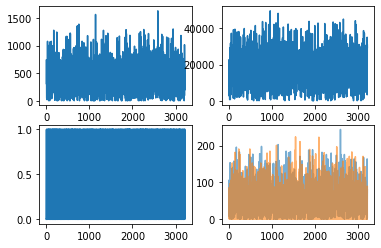

In [7]:
plt.subplot (2, 2, 1)
plt.plot(df['minutes'])
plt.subplot (2, 2, 2)
plt.plot(df['mb_used'])
plt.subplot (2, 2, 3)
plt.plot(df['is_ultra'])
plt.subplot (2, 2, 4)
plt.plot(df[['calls', 'messages']], alpha=0.6)
plt.rcParams["figure.figsize"] = (16,6)
plt.show()

На графиках отсутствуют явные тренды и экстремумы, данные находятся примерно в одном коридоре, из чего следует, что со временем серьёзных изменений в тарифах и ограничений не возникало. Это же дополнительно доказывают графики распределений, имеющие по одному пику, не считая высоких плотностей на значении 0.

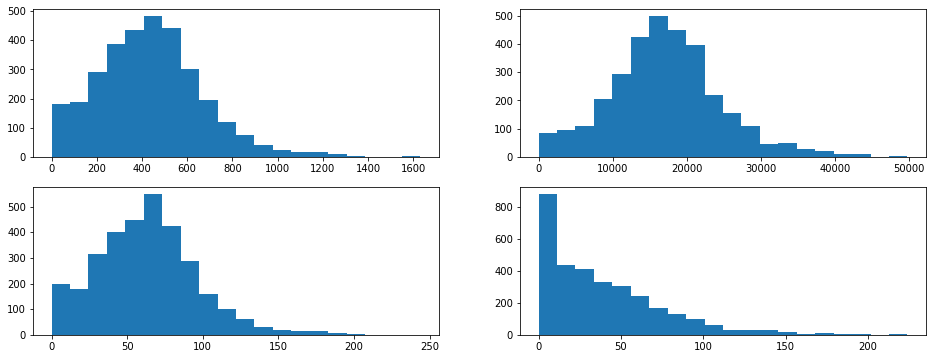

In [8]:
plt.subplot (2, 2, 1)
plt.hist(df['minutes'], bins=20)
plt.subplot (2, 2, 2)
plt.hist(df['mb_used'], bins=20)
plt.subplot (2, 2, 3)
plt.hist(df['calls'], bins=20)
plt.subplot (2, 2, 4)
plt.hist(df['messages'], bins=20)
plt.rcParams["figure.figsize"] = (16,6)
plt.show()

**Вывод**

Изначальные данные выглядят корректными и готовыми к дальнейшей работе.

###### Разбиение данных на выборки

Так как мы проводим работу с ограниченным набором данных, тестовую выборку выделим из имеющегося датафрейма.

Соотношение обучающей, валидационной и тестовой выборки примем за 3:1:1, то есть из датафрейма выделим 1/5 данных и запишем в тестовую выборку.

Выделяем тестовую выборку:

In [9]:
df, df_test = train_test_split(df, test_size=0.2, random_state=666, stratify=df['is_ultra'])

Оставшийся датафрейм разделяем на обучающую и валидационную (25%).

In [10]:
df_train, df_valid = train_test_split(df, test_size=0.25, random_state=777, stratify=df['is_ultra'])

Проверяем размеры выборок:

In [11]:
print(len(df_train))
print(len(df_valid))
print(len(df_test))

1928
643
643


Создадим переменные с признаками. Так как наша цель - решить задачу классификации для выбора подходящего тарифа. Столбец с тарицами, то есть целевым признаком - `is_ultra`.

In [12]:
df_train_features = df_train.drop(['is_ultra'], axis=1)
df_train_target = df_train['is_ultra']

df_valid_features = df_valid.drop(['is_ultra'], axis=1)
df_valid_target = df_valid['is_ultra']

df_test_features = df_test.drop(['is_ultra'], axis=1)
df_test_target = df_test['is_ultra']

**Вывод**

Выборка данных разбита на обучающую, валидационную и тестовую в соотношении 3:1:1. Данные готовы к построению модели.

## Исследование модели

### Решающее дерево

Рассмотрим качество модели, построенной с использованием дерева решений. Изменим гиперпараметр `max_depth` для проверки точности при различной глубине дерева.

In [13]:
best_model_dtc = None
best_result = 0
for depth in range(1, 20):
    model_dtc = DecisionTreeClassifier(random_state=888, max_depth=depth)
    model_dtc.fit(df_train_features, df_train_target)
    predictions_dtc = model_dtc.predict(df_valid_features)
    result_dtc = accuracy_score(df_valid_target, predictions_dtc)
    if result_dtc > best_result:
        best_result = result_dtc
        best_model_dtc = model_dtc
        best_depth = depth
        
print(f'Лучшая глубина - {best_depth}, точность - {best_result}')

Лучшая глубина - 5, точность - 0.8055987558320373


### Случайный лес

Случайный лес также подходит для задачи классификации, проверим эффективность модели этого типа. 
Данный алгоритм показывает наилучшую точность в текущей задаче. Подберём различные значения нескольких гиперпараметров для достижения максимального результата.

Изменяемые гиперпараметры: `n_estimators` (по умолчанию = 100), `min_samples_split`(по умолчанию = 2), 

In [14]:
%%time

best_model_rfc = None
best_result_rfc = 0
for crit in ['gini', 'entropy']:
    for mss in range(2, 4):
        for est in range(1, 100):
            model_rfc = RandomForestClassifier(random_state=666, n_estimators=est, min_samples_split=mss, criterion=crit)
            model_rfc.fit(df_train_features, df_train_target)
            predictions_rfc = model_rfc.predict(df_valid_features)
            result_rfc = accuracy_score(df_valid_target, predictions_rfc)
            if result_rfc > best_result_rfc:
                best_result_rfc = result_rfc
                best_model_rfc = model_rfc
                best_est = est
                best_mss = mss
                best_crit = crit
        
print(f'Количество деревьев - {best_est}, mss - {best_mss}, criterion - {best_crit}, точность - {best_result_rfc}\n')

Количество деревьев - 30, mss - 2, criterion - entropy, точность - 0.8180404354587869

CPU times: user 1min 16s, sys: 207 ms, total: 1min 17s
Wall time: 1min 17s


Достигнута точность 0.818, что лучше результата решающего дерева.

### Логистическая регрессия

Посмотрим на точность модели, построенной методом логистической регрессии. Изменяемый параметр - `max_iter`.

In [15]:
best_model_lr = None
best_result_lr = 0
for it in range(1, 100):
    model_lr = LogisticRegression(random_state=666, solver='lbfgs', max_iter=it)
    model_lr.fit(df_train_features, df_train_target)
    predictions_lr = model_lr.predict(df_valid_features)
    result_lr = accuracy_score(df_valid_target, predictions_lr)
    if result_lr > best_result_lr:
        best_result_lr = result_lr
        best_model_lr = model_lr
        best_iter = it
        
print(f'Количество итераций - {best_iter}, точность - {best_result_lr}')

Количество итераций - 82, точность - 0.7542768273716952


Лучшее количество итераций - 82, точность - 0.754, что гораздо ниже, чем у случайного леса и дерева решений.

Точность модели логистической регрессии слишком низкая, найдём другие гиперпараметры для достижения лучшего результата.

In [16]:
# fit_intercept заменяем True на False
best_model_lr = None
best_result_lr = 0
for it in range(1, 1000):
    model_lr = LogisticRegression(random_state=666, solver='lbfgs', max_iter=it, fit_intercept=False)
    model_lr.fit(df_train_features, df_train_target)
    predictions_lr = model_lr.predict(df_valid_features)
    result_lr = accuracy_score(df_valid_target, predictions_lr)
    if result_lr > best_result_lr:
        best_result_lr = result_lr
        best_model_lr = model_lr
        best_iter = it
        
print(f'Количество итераций - {best_iter}, точность - {best_result_lr}')

Количество итераций - 24, точность - 0.7013996889580093


Точность ухудшилась. Пробуем разные значения `solver`.

In [17]:
best_model_lr = None
best_result_lr = 0
for it in range(1, 100):
    model_lr = LogisticRegression(random_state=666, solver='saga', max_iter=it)
    model_lr.fit(df_train_features, df_train_target)
    predictions_lr = model_lr.predict(df_valid_features)
    result_lr = accuracy_score(df_valid_target, predictions_lr)
    if result_lr > best_result_lr:
        best_result_lr = result_lr
        best_model_lr = model_lr
        best_iter = it
        
print(f'Количество итераций - {best_iter}, точность - {best_result_lr}')

#'newton-cg' - 0.73717
#'liblinear' - 0.73717
#'sag' - 0.69518
#'saga' - 0.69518

Количество итераций - 1, точность - 0.6936236391912908


Пробуем различные значения `multi_class`.

In [18]:
best_model_lr = None
best_result_lr = 0
for it in range(1, 100):
    model_lr = LogisticRegression(random_state=666, solver='lbfgs', max_iter=it, multi_class='ovr')
    model_lr.fit(df_train_features, df_train_target)
    predictions_lr = model_lr.predict(df_valid_features)
    result_lr = accuracy_score(df_valid_target, predictions_lr)
    if result_lr > best_result_lr:
        best_result_lr = result_lr
        best_model_lr = model_lr
        best_iter = it
        
print(f'Количество итераций - {best_iter}, точность - {best_result_lr}')

#'multinomial' - 0.73717

Количество итераций - 82, точность - 0.7542768273716952


Модель "по умолчанию" - лучшая для логистической регрессии, но её точность недостаточна для дальнейшей работы.

In [19]:
# Здесь было про RMSE

### Вывод

Наибольшую точность и наименьшую ошибку показала модель, построенная по алгоритму случайного леса. Параметры следующие:

In [20]:
best_model_rfc

RandomForestClassifier(criterion='entropy', n_estimators=30, random_state=666)

## Проверка модели на тестовой выборке

Проверим выбранную модель на тестовой выборке.

In [21]:
predictions_rfc =  best_model_rfc.predict(df_test_features)
accuracy = accuracy_score(df_test_target, predictions_rfc)
accuracy

0.8040435458786936

На тестовой выборке модель показывает точность 80,40%, что приемлемо для поставленной задачи.

**Вывод**

На тестовой выборке модель показала точность 80,40%. Это меньше, чем на валидационной выборке на 1,4 п.п., но допустимо для решения поставленной задачи.

## (бонус) Проверка модели на адекватность

На тестовой выборке точность модели меньше, чем на валидационной. Проверим адекватность модели. Ранее мы вычислили, что распределение целевого признака в исходных данных - 0.694/0.306. Проверим точность предсказаний на константной модели:

In [22]:
target_pred_constant = pd.Series(0, df_train_target.index)
accuracy_score(df_train_target, target_pred_constant)

0.6934647302904564

В исходных данных имеется перевес в сторону категории "0" - в 2,3 раза больше. Для лучшего обучения модели необходимо соотношение классов близкое к 1:1.

## Вывод

Построена модель для подбора наиболее эффективного тарифа на основании количества используемых услуг. Наибольшую точность показала модель, построенная методом случайного леса - 81.80% на валидационной и 80.40% на тестовой выборке. Предполагаем, что такая точность вызвана неэффективным использованием услуг клиентами или ошибочным выбором невыгодного тарифа среди некоторых пользователей. 

Количества данных для каждого тарифа достаточно для подтверждения корректности модели.

## Чек-лист готовности проекта

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
